In [9]:
import pandas as pd
import os
import re
import numpy as np

# --- 1. Sabit Dizin Yolları ve Model Adlandırma Kuralları ---

BASE_DAM_MODELS_DIR = "../models"
GENERAL_DAM_MODELS_DIR = "../models/general_dam"
ALL_DAMS_SYSTEM_WIDE_MODELS_DIR = "../models/all_dams_system_wide"

dam_names = [
    "Omerli", "Darlik", "Elmali", "Terkos", "Alibey",
    "Buyukcekmece", "Sazlidere", "Kazandere", "Pabucdere", "Istrancalar"
]

MODEL_METRICS_TEMPLATES = {
    "Univariate_LSTM_Only_Occupancy": "lstm_univariate_only_occupancy_metrics.txt",
    "Multivariate_LSTM_Occupancy_Only": "lstm_multivariate_occupancy_only_metrics.txt",
    "Single_Dam_Multivariate_LSTM_Extra_Inputs": "lstm_multivariate_extra_inputs_metrics.txt",
    "Prophet_Multivariate_Extra_Inputs": "prophet_multivariate_extra_inputs_metrics.txt",
}

# --- 2. Metrikleri Okuma Fonksiyonu ---
def read_metrics_from_file(file_path, specific_dam_name=None):
    metrics = {}
    if not os.path.exists(file_path):
        return None

    try:
        with open(file_path, "r") as f:
            lines = f.readlines()
        
        # Check for model type C's multi-line format
        if lines and "Model Type: All Dams Multivariate LSTM" in lines[0]: # Added 'if lines' check
            for line in lines[1:]:
                match = re.match(r"(.+?) - MAE: ([\d.]+), RMSE: ([\d.]+)", line)
                if match:
                    dam_name = match.group(1).strip()
                    mae = float(match.group(2))
                    rmse = float(match.group(3))
                    metrics[dam_name] = {'MAE': mae, 'RMSE': rmse}
            return metrics
        
        else: # Standard single-dam metrics file
            # Corrected regex for literal dot: r"MAE: ([\d.]+)" -> r"MAE: ([\d.]+)"
            mae_match = re.search(r"MAE: ([\d.]+)", lines[0]) 
            rmse_match = re.search(r"RMSE: ([\d.]+)", lines[1])

            if mae_match and rmse_match:
                mae = float(mae_match.group(1))
                rmse = float(rmse_match.group(1))
                metrics[specific_dam_name] = {'MAE': mae, 'RMSE': rmse}
                return metrics
            
    except Exception as e:
        print(f"  > Error reading metrics from {file_path}: {e}")
    return None

# --- 3. Sonuçları Toplamak İçin DataFrame ---
all_results = []

print("Collecting model performance metrics...")

# --- 4. Bireysel Baraj Modellerinin Metriklerini Toplama ---
for dam in dam_names:
    dam_folder_path = os.path.join(BASE_DAM_MODELS_DIR, dam.lower())
    
    for model_type, file_template in MODEL_METRICS_TEMPLATES.items():
        file_path = os.path.join(dam_folder_path, file_template)
        
        if os.path.exists(file_path):
            metrics_data = read_metrics_from_file(file_path, specific_dam_name=dam)
            if metrics_data:
                for d_name, m_values in metrics_data.items():
                    all_results.append({
                        'Dam': d_name,
                        'Model Type': model_type,
                        'MAE': m_values['MAE'],
                        'RMSE': m_values['RMSE']
                    })
        # No more intermediate prints here, as per user's request.

# --- 5. Genel/Sistem Çapındaki Modellerin Metriklerini Toplama ---
print("  > Collecting metrics for System-Wide Models and General Models...")

all_dams_lstm_metrics_file = os.path.join(ALL_DAMS_SYSTEM_WIDE_MODELS_DIR, "lstm_all_dams_multivariate_metrics.txt")
metrics_data_c = read_metrics_from_file(all_dams_lstm_metrics_file)
if metrics_data_c:
    for dam_name_c, m_values_c in metrics_data_c.items():
        all_results.append({
            'Dam': dam_name_c,
            'Model Type': "All_Dams_Multivariate_LSTM",
            'MAE': m_values_c['MAE'],
            'RMSE': m_values_c['RMSE']
        })

prophet_general_metrics_file = os.path.join(GENERAL_DAM_MODELS_DIR, "prophet_general_dam_only_occupancy_metrics.txt")
metrics_data_prophet_general = read_metrics_from_file(prophet_general_metrics_file, specific_dam_name="Aggregated_General_Occupancy")
if metrics_data_prophet_general:
    for d_name, m_values in metrics_data_prophet_general.items():
        all_results.append({
            'Dam': d_name,
            'Model Type': "Prophet_General_Only_Occupancy",
            'MAE': m_values['MAE'],
            'RMSE': m_values['RMSE']
        })

sarima_general_metrics_file = os.path.join(GENERAL_DAM_MODELS_DIR, "sarima_general_dam_only_occupancy_metrics.txt")
metrics_data_sarima_general = read_metrics_from_file(sarima_general_metrics_file, specific_dam_name="Aggregated_General_Occupancy")
if metrics_data_sarima_general:
    for d_name, m_values in metrics_data_sarima_general.items():
        all_results.append({
            'Dam': d_name,
            'Model Type': "SARIMA_General_Only_Occupancy",
            'MAE': m_values['MAE'],
            'RMSE': m_values['RMSE']
        })

# Sonuç DataFrame'i oluşturma
results_df = pd.DataFrame(all_results)

# --- 6. Sonuçları Analiz Etme ve Kaydetme ---
if results_df.empty:
    print("\nNo model metrics found. Please ensure models are trained and metrics files exist in the specified paths.")
else:
    print("\n--- Model Comparison Results ---")
    print(results_df.to_string())

    # Her Baraj İçin En İyi Modeli Bulma (MAE'ye Göre)
    individual_dam_results = results_df[results_df['Dam'].isin(dam_names)].copy()
    if not individual_dam_results.empty:
        best_models_per_dam_mae = individual_dam_results.loc[individual_dam_results.groupby('Dam')['MAE'].idxmin()].sort_values(by=['Dam'])
        print("\n--- Best Model Per Dam (Ranked by MAE) ---")
        print(best_models_per_dam_mae.to_string())
    else:
        print("  > No individual dam model metrics found for ranking.")
        best_models_per_dam_mae = pd.DataFrame() # Create empty DataFrame if no results

    # Her Baraj İçin En İyi İlk 2 Modeli Bulma (MAE'ye Göre)
    best_2_models_per_dam = individual_dam_results.groupby('Dam').apply(lambda x: x.nsmallest(2, 'MAE')).reset_index(drop=True)
    print("\n--- Best 2 Models Per Dam (Ranked by MAE) ---")
    print(best_2_models_per_dam.to_string())

    # Genel Modellerin Performansı
    print("\n--- Performance of General/Aggregated Models ---")
    general_models_results = results_df[results_df['Dam'] == "Aggregated_General_Occupancy"].copy()
    if not general_models_results.empty:
        print(general_models_results.sort_values(by='MAE').to_string())
    else:
        print("  > No general/aggregated model metrics found.")

    # --- 7. Sonuçları CSV Dosyalarına Kaydetme ---
    output_dir = "../results/model_selection"
    os.makedirs(output_dir, exist_ok=True) # Create folder if it doesn't exist

    # Tüm Sonuçları Kaydet
    results_df.to_csv(os.path.join(output_dir, "all_model_metrics.csv"), index=False)
    print(f"\n> All model metrics saved to: {os.path.join(output_dir, 'all_model_metrics.csv')}")

    # En İyi Modelleri Kaydet (Her baraj için en iyi)
    if not best_models_per_dam_mae.empty:
        best_models_per_dam_mae.to_csv(os.path.join(output_dir, "best_model_per_dam.csv"), index=False)
        print(f"> Best model per dam saved to: {os.path.join(output_dir, 'best_model_per_dam.csv')}")
    else:
         print("> No best model per dam to save.")

    # En İyi İlk 2 Modeli Kaydet (Her baraj için en iyi 2)
    best_2_models_per_dam.to_csv(os.path.join(output_dir, "best_2_models_per_dam.csv"), index=False)
    print(f"> Best 2 models per dam saved to: {os.path.join(output_dir, 'best_2_models_per_dam.csv')}")

print("\nModel comparison and ranking process completed.")

  > Collecting metrics for System-Wide Models and General Models...

--- Model Comparison Results ---
                             Dam                                 Model Type     MAE    RMSE
0                         Omerli             Univariate_LSTM_Only_Occupancy  0.0034  0.0070
1                         Omerli           Multivariate_LSTM_Occupancy_Only  0.0104  0.0151
2                         Omerli  Single_Dam_Multivariate_LSTM_Extra_Inputs  0.0041  0.0080
3                         Omerli          Prophet_Multivariate_Extra_Inputs  0.0155  0.0212
4                         Darlik             Univariate_LSTM_Only_Occupancy  0.0042  0.0087
5                         Darlik           Multivariate_LSTM_Occupancy_Only  0.0063  0.0108
6                         Darlik  Single_Dam_Multivariate_LSTM_Extra_Inputs  0.0066  0.0132
7                         Darlik          Prophet_Multivariate_Extra_Inputs  0.0154  0.0233
8                         Elmali             Univariate_LSTM_Only_Occu

C:\Users\merta\AppData\Local\Temp\ipykernel_29504\596829271.py:141: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_2_models_per_dam = individual_dam_results.groupby('Dam').apply(lambda x: x.nsmallest(2, 'MAE')).reset_index(drop=True)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model
import tensorflow as tf # TensorFlow kütüphanesi eklendi
import joblib, os

# --- 1. Sabit Dizin Yolları (Klasör Yapınıza Göre Güncellendi) ---

# Model Tipi A: Tek Değişkenli LSTM (Sadece Kendi Doluluğuna Bakan)
MODEL_A_DIR = "../models/multivariate_models_only_occupancy/lstm_univariate"
SCALER_A_DIR = os.path.join(MODEL_A_DIR, "scalers")

# Model Tipi B: Tek Baraja Odaklı Çok Değişkenli LSTM (Doluluk + Yağış + Tüketim + Lag/Rolling Mean)
MODEL_B_DIR = "../models/multivariate_models_with_extra_inputs/lstm_univariate"
SCALER_B_DIR = os.path.join(MODEL_B_DIR, "scalers")

# Model Tipi C: Tüm Barajları Kapsayan Çok Değişkenli LSTM (Tüm Baraj Dolulukları + Tüm Yağışlar + Tüketim)
MODEL_C_DIR = "../models/multivariate_models_with_extra_inputs/lstm_multivariate_all_dams_from_specific"
SCALER_C_DIR = os.path.join(MODEL_C_DIR, "scalers")

# Model Tipi D: Çok Değişkenli LSTM (Sadece Doluluk Oranları, Tüm Barajlar)
MODEL_D_DIR = "../models/multivariate_models_only_occupancy/lstm_multivariate"
SCALER_D_DIR = os.path.join(MODEL_D_DIR, "scalers")


# --- 2. Ortak Veri Yükleme ve Hazırlık ---
# merged_dam_specific: Hem doluluk, hem yağış, hem tüketim içerir.
df_specific = pd.read_csv("../data/processed/merged_dam_specific.csv")
df_specific['Tarih'] = pd.to_datetime(df_specific['Tarih'])
df_specific.interpolate(method='linear', inplace=True)
df_specific.dropna(inplace=True)

# istanbul-dams-daily-occupancy-rates-cleaned: Sadece doluluk oranları içerir.
df_occupancy_only = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df_occupancy_only['Tarih'] = pd.to_datetime(df_occupancy_only['Tarih'])
df_occupancy_only.interpolate(method='linear', inplace=True)
df_occupancy_only.dropna(inplace=True)


# İlgili sütunları alalım (DÜZELTME: rainfall_cols_specific tanımı eklendi)
dam_fill_cols_specific = [col for col in df_specific.columns if col.endswith('_Fill')]
dam_occupancy_only_cols = [col for col in df_occupancy_only.columns if col != 'Tarih']
consumption_col_specific = 'Istanbul_Daily_Consumption'
rainfall_cols_specific = [col for col in df_specific.columns if col.endswith('_Rainfall')] # <<< BU SATIR EKLENDİ/DÜZELTİLDİ


# Sekans oluşturma fonksiyonu
def create_sequences(data, time_steps=60, target_indices=None):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps), :])
        if target_indices is not None:
            ys.append(data[i + time_steps, target_indices])
        else: 
            ys.append(data[i + time_steps, 0]) 
    return np.array(Xs), np.array(ys)

results_df = pd.DataFrame(columns=['Model Type', 'Dam', 'MAE', 'RMSE'])

# --- 3. Model Tiplerini Karşılaştırma Döngüsü ---

# MODEL TİPİ A: Tek Değişkenli LSTM (Sadece Kendi Doluluğuna Bakan)
print("--- Evaluating Model Type A: Univariate LSTM (Single Dam Occupancy Only) ---")
TIME_STEPS_A = 60 
for dam_name in dam_occupancy_only_cols: 
    model_path = os.path.join(MODEL_A_DIR, f"lstm_{dam_name.lower()}.h5")
    scaler_path = os.path.join(SCALER_A_DIR, f"scaler_{dam_name.lower()}.pkl")
    
    if os.path.exists(model_path) and os.path.exists(scaler_path):
        try:
            model = load_model(model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
            scaler = joblib.load(scaler_path)

            series_data = df_occupancy_only[[dam_name]].values 
            scaled_series = scaler.transform(series_data)
            
            X_seq, y_seq = create_sequences(scaled_series, time_steps=TIME_STEPS_A, target_indices=[0])
            
            train_size = int(len(X_seq) * 0.7)
            val_size = int(len(X_seq) * 0.1)
            X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
            
            predictions_scaled = model.predict(X_test)
            
            y_test_inv = scaler.inverse_transform(y_test).flatten()
            predictions_inv = scaler.inverse_transform(predictions_scaled).flatten()
            
            mae = mean_absolute_error(y_test_inv, predictions_inv)
            rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
            
            results_df = pd.concat([results_df, pd.DataFrame([['Univariate_LSTM_Only_Occupancy', dam_name, mae, rmse]], columns=results_df.columns)], ignore_index=True)
            print(f"  {dam_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
            
        except Exception as e:
            print(f"  Error evaluating Model A for {dam_name}: {e}")
            print(f"  Details: {e}")
    else:
        print(f"  Model A (Univariate LSTM) model/scaler not found for {dam_name}.")


# MODEL TİPİ B: Tek Baraja Odaklı Çok Değişkenli LSTM (Doluluk + Yağış + Tüketim + Lag/Rolling Mean)
print("\n--- Evaluating Model Type B: Single Dam Multivariate LSTM (with Extra Inputs) ---")
TIME_STEPS_B = 60
for dam_col_fill in dam_fill_cols_specific:
    dam_name_base = dam_col_fill.replace('_Fill', '')
    rainfall_col = f"{dam_name_base}_Rainfall"
    
    model_b_base_features = [dam_col_fill, rainfall_col, consumption_col_specific]
    model_b_features_extended = model_b_base_features + [f'{dam_col_fill}_lag1', f'{dam_col_fill}_rolling7']
    
    model_path = os.path.join(MODEL_B_DIR, f"lstm_{dam_name_base.lower()}.h5")
    scaler_path = os.path.join(SCALER_B_DIR, f"scaler_{dam_name_base.lower()}.pkl")

    if os.path.exists(model_path) and os.path.exists(scaler_path) and rainfall_col in df_specific.columns:
        try:
            model = load_model(model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
            scaler = joblib.load(scaler_path)

            df_model_current_dam = df_specific[['Tarih'] + model_b_base_features].copy()
            
            df_model_current_dam[f'{dam_col_fill}_lag1'] = df_model_current_dam[dam_col_fill].shift(1)
            df_model_current_dam[f'{dam_col_fill}_rolling7'] = df_model_current_dam[dam_col_fill].rolling(window=7).mean()
            df_model_current_dam.dropna(inplace=True)
            
            scaled_data = scaler.transform(df_model_current_dam[model_b_features_extended])

            X_seq, y_seq = create_sequences(scaled_data, time_steps=TIME_STEPS_B, target_indices=[0])

            train_size = int(len(X_seq) * 0.7)
            val_size = int(len(X_seq) * 0.1)
            X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
            
            predictions_scaled = model.predict(X_test)
            
            full_predictions_scaled_temp = np.zeros((predictions_scaled.shape[0], len(model_b_features_extended)))
            full_y_test_scaled_temp = np.zeros((y_test.shape[0], len(model_b_features_extended)))

            full_predictions_scaled_temp[:, 0] = predictions_scaled.flatten()
            full_y_test_scaled_temp[:, 0] = y_test.flatten()

            full_predictions_scaled_temp[:, 1:] = X_test[:, -1, 1:]
            full_y_test_scaled_temp[:, 1:] = X_test[:, -1, 1:]

            predictions_inv = scaler.inverse_transform(full_predictions_scaled_temp)[:, 0]
            y_test_inv = scaler.inverse_transform(full_y_test_scaled_temp)[:, 0]

            mae = mean_absolute_error(y_test_inv, predictions_inv)
            rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
            
            results_df = pd.concat([results_df, pd.DataFrame([['Single_Dam_Multivariate_LSTM', dam_name_base, mae, rmse]], columns=results_df.columns)], ignore_index=True)
            print(f"  {dam_name_base} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

        except Exception as e:
            print(f"  Error evaluating Model B for {dam_name_base}: {e}")
            print(f"  Details: {e}")
    else:
        print(f"  Model B (Single Dam Multivariate LSTM) model/scaler/rainfall data not found for {dam_name_base}.")


# MODEL TİPİ C: Tüm Barajları Kapsayan Çok Değişkenli LSTM (Tüm Baraj Dolulukları + Tüm Yağışlar + Tüketim)
print("\n--- Evaluating Model Type C: All Dams Multivariate LSTM ---")
TIME_STEPS_C = 60 

all_features_for_model_C = dam_fill_cols_specific + rainfall_cols_specific + [consumption_col_specific]

model_path = os.path.join(MODEL_C_DIR, "lstm_all_dams_specific.h5")
scaler_path = os.path.join(SCALER_C_DIR, "scaler_X_all_dams_specific.pkl")

if os.path.exists(model_path) and os.path.exists(scaler_path):
    try:
        model = load_model(model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
        scaler = joblib.load(scaler_path)

        scaled_data = scaler.transform(df_specific[all_features_for_model_C])
        
        target_indices_C = [all_features_for_model_C.index(col) for col in dam_fill_cols_specific]
        
        X_seq, y_seq = create_sequences(scaled_data, time_steps=TIME_STEPS_C, target_indices=target_indices_C)
        
        train_size = int(len(X_seq) * 0.7)
        val_size = int(len(X_seq) * 0.1)
        X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
        
        predictions_scaled = model.predict(X_test)
        
        num_features_total_C = len(all_features_for_model_C)
        full_predictions_scaled_C = np.zeros((predictions_scaled.shape[0], num_features_total_C))
        full_y_test_scaled_C = np.zeros((y_test.shape[0], num_features_total_C))

        full_predictions_scaled_C[:, target_indices_C] = predictions_scaled
        full_y_test_scaled_C[:, target_indices_C] = y_test

        other_feature_indices_C = [i for i in range(num_features_total_C) if i not in target_indices_C]
        full_predictions_scaled_C[:, other_feature_indices_C] = X_test[:, -1, other_feature_indices_C]
        full_y_test_scaled_C[:, other_feature_indices_C] = X_test[:, -1, other_feature_indices_C]

        predictions_inv = scaler.inverse_transform(full_predictions_scaled_C)
        y_test_inv = scaler.inverse_transform(full_y_test_scaled_C)

        for i, dam_col_fill in enumerate(dam_fill_cols_specific):
            dam_name_base = dam_col_fill.replace('_Fill', '')
            mae = mean_absolute_error(y_test_inv[:, target_indices_C[i]], predictions_inv[:, target_indices_C[i]])
            rmse = np.sqrt(mean_squared_error(y_test_inv[:, target_indices_C[i]], predictions_inv[:, target_indices_C[i]]))
            results_df = pd.concat([results_df, pd.DataFrame([['All_Dams_Multivariate_LSTM', dam_name_base, mae, rmse]], columns=results_df.columns)], ignore_index=True)
            print(f"  {dam_name_base} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    except Exception as e:
        print(f"  Error evaluating Model C: {e}")
        print(f"  Details: {e}")
else:
    print(f"  Model C (All Dams Multivariate LSTM) model/scaler not found.")

# MODEL TİPİ D: Çok Değişkenli LSTM (Sadece Doluluk Oranları, Tüm Barajlar)
print("\n--- Evaluating Model Type D: Multivariate LSTM (Occupancy Only - All Dams Inputs) ---")
TIME_STEPS_D = 60 

all_occupancy_cols_for_model_D = dam_occupancy_only_cols 

for dam_name_base in dam_occupancy_only_cols: 
    model_path = os.path.join(MODEL_D_DIR, f"lstm_multi_{dam_name_base.lower()}.h5")
    scaler_X_D_path = os.path.join(SCALER_D_DIR, "scaler_X.pkl")
    scaler_y_D_path = os.path.join(SCALER_D_DIR, f"scaler_y_{dam_name_base.lower()}.pkl")

    if os.path.exists(model_path) and os.path.exists(scaler_X_D_path) and os.path.exists(scaler_y_D_path):
        try:
            model = load_model(model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
            scaler_X_D = joblib.load(scaler_X_D_path)
            scaler_y_D = joblib.load(scaler_y_D_path)

            X_data_D = df_occupancy_only[all_occupancy_cols_for_model_D].values
            X_scaled_D = scaler_X_D.transform(X_data_D)

            y_data_D = df_occupancy_only[[dam_name_base]].values
            y_scaled_D = scaler_y_D.transform(y_data_D)

            Xs, _ = create_sequences(X_scaled_D, time_steps=TIME_STEPS_D, target_indices=[0])
            
            ys_seq_D = y_scaled_D[TIME_STEPS_D:].flatten()

            train_size = int(len(Xs) * 0.7)
            val_size = int(len(Xs) * 0.1)
            X_test, y_test = Xs[train_size + val_size:], ys_seq_D[train_size + val_size:]
            
            predictions_scaled = model.predict(X_test).flatten()

            y_test_inv = scaler_y_D.inverse_transform(y_test.reshape(-1, 1)).flatten()
            predictions_inv = scaler_y_D.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()

            mae = mean_absolute_error(y_test_inv, predictions_inv)
            rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
            
            results_df = pd.concat([results_df, pd.DataFrame([['Multivariate_LSTM_Occupancy_Only', dam_name_base, mae, rmse]], columns=results_df.columns)], ignore_index=True)
            print(f"  {dam_name_base} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

        except Exception as e:
            print(f"  Error evaluating Model D for {dam_name_base}: {e}")
            print(f"  Details: {e}")
    else:
        print(f"  Model D (Multivariate LSTM Occupancy Only) model/scalers not found for {dam_name_base}.")


# --- 4. Sonuçları Görüntüleme ---
print("\n--- Comparison Results ---")
print(results_df)

print("\n--- Average Performance by Model Type ---")
print(results_df.groupby('Model Type')[['MAE', 'RMSE']].mean())
You're right! My apologies for the oversight. It looks like the `rainfall_cols_specific` variable was indeed missing its definition. I've corrected that in the code snippet below.

Additionally, the `FutureWarning` about `pd.concat` is just a warning, not an error that stops the code. It indicates that a future version of Pandas might change how concatenation handles empty or all-NA columns. It's generally harmless for now but good to be aware of.

The `WARNING:absl:Compiled the loaded model, but the compiled metrics have yet to be built` is also a warning from Keras/TensorFlow, usually appearing when you load a model that was compiled but then only used for `predict` or `evaluate` without `model.compile()` being called again on the loaded model. It's informational and often doesn't affect `predict` results, as long as the model structure and weights are loaded correctly. My addition of `custom_objects={'mse': tf.keras.losses.MeanSquaredError()}` for `load_model` is a good practice to ensure `mse` is correctly recognized.

Here's the corrected and complete code for comparing your models, including the fix for `rainfall_cols_specific`. Please ensure you run the **entire notebook cell from top to bottom** to make sure all variables are defined in sequence.

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import load_model
import tensorflow as tf
import joblib, os

# --- 1. Sabit Dizin Yolları (Klasör Yapınıza Göre Güncellendi) ---

# Model Tipi A: Tek Değişkenli LSTM (Sadece Kendi Doluluğuna Bakan)
MODEL_A_DIR = "../models/multivariate_models_only_occupancy/lstm_univariate"
SCALER_A_DIR = os.path.join(MODEL_A_DIR, "scalers")

# Model Tipi B: Tek Baraja Odaklı Çok Değişkenli LSTM (Doluluk + Yağış + Tüketim + Lag/Rolling Mean)
MODEL_B_DIR = "../models/multivariate_models_with_extra_inputs/lstm_univariate"
SCALER_B_DIR = os.path.join(MODEL_B_DIR, "scalers")

# Model Tipi C: Tüm Barajları Kapsayan Çok Değişkenli LSTM (Tüm Baraj Dolulukları + Tüm Yağışlar + Tüketim)
MODEL_C_DIR = "../models/multivariate_models_with_extra_inputs/lstm_multivariate_all_dams_from_specific"
SCALER_C_DIR = os.path.join(MODEL_C_DIR, "scalers")

# Model Tipi D: Çok Değişkenli LSTM (Sadece Doluluk Oranları, Tüm Barajlar)
MODEL_D_DIR = "../models/multivariate_models_only_occupancy/lstm_multivariate"
SCALER_D_DIR = os.path.join(MODEL_D_DIR, "scalers")


# --- 2. Ortak Veri Yükleme ve Hazırlık ---
# merged_dam_specific: Hem doluluk, hem yağış, hem tüketim içerir.
df_specific = pd.read_csv("../data/processed/merged_dam_specific.csv")
df_specific['Tarih'] = pd.to_datetime(df_specific['Tarih'])
df_specific.interpolate(method='linear', inplace=True)
df_specific.dropna(inplace=True)

# istanbul-dams-daily-occupancy-rates-cleaned: Sadece doluluk oranları içerir.
df_occupancy_only = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df_occupancy_only['Tarih'] = pd.to_datetime(df_occupancy_only['Tarih'])
df_occupancy_only.interpolate(method='linear', inplace=True)
df_occupancy_only.dropna(inplace=True)


# İlgili sütunları alalım (DÜZELTME: rainfall_cols_specific tanımı eklendi)
dam_fill_cols_specific = [col for col in df_specific.columns if col.endswith('_Fill')]
dam_occupancy_only_cols = [col for col in df_occupancy_only.columns if col != 'Tarih']
consumption_col_specific = 'Istanbul_Daily_Consumption'
rainfall_cols_specific = [col for col in df_specific.columns if col.endswith('_Rainfall')] # <<< BU SATIR EKLENDİ


# Sekans oluşturma fonksiyonu
def create_sequences(data, time_steps=60, target_indices=None):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps), :])
        if target_indices is not None:
            ys.append(data[i + time_steps, target_indices])
        else: 
            ys.append(data[i + time_steps, 0]) 
    return np.array(Xs), np.array(ys)

results_df = pd.DataFrame(columns=['Model Type', 'Dam', 'MAE', 'RMSE'])

# --- 3. Model Tiplerini Karşılaştırma Döngüsü ---

# MODEL TİPİ A: Tek Değişkenli LSTM (Sadece Kendi Doluluğuna Bakan)
print("--- Evaluating Model Type A: Univariate LSTM (Single Dam Occupancy Only) ---")
TIME_STEPS_A = 60 
for dam_name in dam_occupancy_only_cols: 
    model_path = os.path.join(MODEL_A_DIR, f"lstm_{dam_name.lower()}.h5")
    scaler_path = os.path.join(SCALER_A_DIR, f"scaler_{dam_name.lower()}.pkl")
    
    if os.path.exists(model_path) and os.path.exists(scaler_path):
        try:
            model = load_model(model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
            scaler = joblib.load(scaler_path)

            series_data = df_occupancy_only[[dam_name]].values 
            scaled_series = scaler.transform(series_data)
            
            # create_sequences'a `target_indices`'i bir liste olarak veriyoruz
            X_seq, y_seq = create_sequences(scaled_series, time_steps=TIME_STEPS_A, target_indices=[0]) 
            
            train_size = int(len(X_seq) * 0.7)
            val_size = int(len(X_seq) * 0.1)
            X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
            
            predictions_scaled = model.predict(X_test)
            
            # y_test ve predictions_scaled zaten 2D olması muhtemel
            y_test_inv = scaler.inverse_transform(y_test).flatten() 
            predictions_inv = scaler.inverse_transform(predictions_scaled).flatten()
            
            mae = mean_absolute_error(y_test_inv, predictions_inv)
            rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
            
            results_df = pd.concat([results_df, pd.DataFrame([['Univariate_LSTM_Only_Occupancy', dam_name, mae, rmse]], columns=results_df.columns)], ignore_index=True)
            print(f"  {dam_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
            
        except Exception as e:
            print(f"  Error evaluating Model A for {dam_name}: {e}")
            print(f"  Details: {e}")
    else:
        print(f"  Model A (Univariate LSTM) model/scaler not found for {dam_name}.")


# MODEL TİPİ B: Tek Baraja Odaklı Çok Değişkenli LSTM (Doluluk + Yağış + Tüketim + Lag/Rolling Mean)
print("\n--- Evaluating Model Type B: Single Dam Multivariate LSTM (with Extra Inputs) ---")
TIME_STEPS_B = 60
for dam_col_fill in dam_fill_cols_specific:
    dam_name_base = dam_col_fill.replace('_Fill', '')
    rainfall_col = f"{dam_name_base}_Rainfall"
    
    model_b_base_features = [dam_col_fill, rainfall_col, consumption_col_specific]
    model_b_features_extended = model_b_base_features + [f'{dam_col_fill}_lag1', f'{dam_col_fill}_rolling7']
    
    model_path = os.path.join(MODEL_B_DIR, f"lstm_{dam_name_base.lower()}.h5")
    scaler_path = os.path.join(SCALER_B_DIR, f"scaler_{dam_name_base.lower()}.pkl")

    if os.path.exists(model_path) and os.path.exists(scaler_path) and rainfall_col in df_specific.columns:
        try:
            model = load_model(model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
            scaler = joblib.load(scaler_path)

            df_model_current_dam = df_specific[['Tarih'] + model_b_base_features].copy()
            
            df_model_current_dam[f'{dam_col_fill}_lag1'] = df_model_current_dam[dam_col_fill].shift(1)
            df_model_current_dam[f'{dam_col_fill}_rolling7'] = df_model_current_dam[dam_col_fill].rolling(window=7).mean()
            df_model_current_dam.dropna(inplace=True)
            
            scaled_data = scaler.transform(df_model_current_dam[model_b_features_extended])

            X_seq, y_seq = create_sequences(scaled_data, time_steps=TIME_STEPS_B, target_indices=[0])

            train_size = int(len(X_seq) * 0.7)
            val_size = int(len(X_seq) * 0.1)
            X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
            
            predictions_scaled = model.predict(X_test)
            
            full_predictions_scaled_temp = np.zeros((predictions_scaled.shape[0], len(model_b_features_extended)))
            full_y_test_scaled_temp = np.zeros((y_test.shape[0], len(model_b_features_extended)))

            full_predictions_scaled_temp[:, 0] = predictions_scaled.flatten()
            full_y_test_scaled_temp[:, 0] = y_test.flatten()

            full_predictions_scaled_temp[:, 1:] = X_test[:, -1, 1:]
            full_y_test_scaled_temp[:, 1:] = X_test[:, -1, 1:]

            predictions_inv = scaler.inverse_transform(full_predictions_scaled_temp)[:, 0]
            y_test_inv = scaler.inverse_transform(full_y_test_scaled_temp)[:, 0]

            mae = mean_absolute_error(y_test_inv, predictions_inv)
            rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
            
            results_df = pd.concat([results_df, pd.DataFrame([['Single_Dam_Multivariate_LSTM', dam_name_base, mae, rmse]], columns=results_df.columns)], ignore_index=True)
            print(f"  {dam_name_base} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

        except Exception as e:
            print(f"  Error evaluating Model B for {dam_name_base}: {e}")
            print(f"  Details: {e}")
    else:
        print(f"  Model B (Single Dam Multivariate LSTM) model/scaler/rainfall data not found for {dam_name_base}.")


# MODEL TİPİ C: Tüm Barajları Kapsayan Çok Değişkenli LSTM (Tüm Baraj Dolulukları + Tüm Yağışlar + Tüketim)
print("\n--- Evaluating Model Type C: All Dams Multivariate LSTM ---")
TIME_STEPS_C = 60 

all_features_for_model_C = dam_fill_cols_specific + rainfall_cols_specific + [consumption_col_specific]

model_path = os.path.join(MODEL_C_DIR, "lstm_all_dams_specific.h5")
scaler_path = os.path.join(SCALER_C_DIR, "scaler_X_all_dams_specific.pkl")

if os.path.exists(model_path) and os.path.exists(scaler_path):
    try:
        model = load_model(model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
        scaler = joblib.load(scaler_path)

        scaled_data = scaler.transform(df_specific[all_features_for_model_C])
        
        target_indices_C = [all_features_for_model_C.index(col) for col in dam_fill_cols_specific]
        
        X_seq, y_seq = create_sequences(scaled_data, time_steps=TIME_STEPS_C, target_indices=target_indices_C)
        
        train_size = int(len(X_seq) * 0.7)
        val_size = int(len(X_seq) * 0.1)
        X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
        
        predictions_scaled = model.predict(X_test)
        
        num_features_total_C = len(all_features_for_model_C)
        full_predictions_scaled_C = np.zeros((predictions_scaled.shape[0], num_features_total_C))
        full_y_test_scaled_C = np.zeros((y_test.shape[0], num_features_total_C))

        full_predictions_scaled_C[:, target_indices_C] = predictions_scaled
        full_y_test_scaled_C[:, target_indices_C] = y_test

        other_feature_indices_C = [i for i in range(num_features_total_C) if i not in target_indices_C]
        full_predictions_scaled_C[:, other_feature_indices_C] = X_test[:, -1, other_feature_indices_C]
        full_y_test_scaled_C[:, other_feature_indices_C] = X_test[:, -1, other_feature_indices_C]

        predictions_inv = scaler.inverse_transform(full_predictions_scaled_C)
        y_test_inv = scaler.inverse_transform(full_y_test_scaled_C)

        for i, dam_col_fill in enumerate(dam_fill_cols_specific):
            dam_name_base = dam_col_fill.replace('_Fill', '')
            mae = mean_absolute_error(y_test_inv[:, target_indices_C[i]], predictions_inv[:, target_indices_C[i]])
            rmse = np.sqrt(mean_squared_error(y_test_inv[:, target_indices_C[i]], predictions_inv[:, target_indices_C[i]]))
            results_df = pd.concat([results_df, pd.DataFrame([['All_Dams_Multivariate_LSTM', dam_name_base, mae, rmse]], columns=results_df.columns)], ignore_index=True)
            print(f"  {dam_name_base} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    except Exception as e:
        print(f"  Error evaluating Model C: {e}")
        print(f"  Details: {e}")
else:
    print(f"  Model C (All Dams Multivariate LSTM) model/scaler not found.")

# MODEL TİPİ D: Çok Değişkenli LSTM (Sadece Doluluk Oranları, Tüm Barajlar)
print("\n--- Evaluating Model Type D: Multivariate LSTM (Occupancy Only - All Dams Inputs) ---")
TIME_STEPS_D = 60 

all_occupancy_cols_for_model_D = dam_occupancy_only_cols 

for dam_name_base in dam_occupancy_only_cols: 
    model_path = os.path.join(MODEL_D_DIR, f"lstm_multi_{dam_name_base.lower()}.h5")
    scaler_X_D_path = os.path.join(SCALER_D_DIR, "scaler_X.pkl")
    scaler_y_D_path = os.path.join(SCALER_D_DIR, f"scaler_y_{dam_name_base.lower()}.pkl")

    if os.path.exists(model_path) and os.path.exists(scaler_X_D_path) and os.path.exists(scaler_y_D_path):
        try:
            model = load_model(model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
            scaler_X_D = joblib.load(scaler_X_D_path)
            scaler_y_D = joblib.load(scaler_y_D_path)

            X_data_D = df_occupancy_only[all_occupancy_cols_for_model_D].values
            X_scaled_D = scaler_X_D.transform(X_data_D)

            y_data_D = df_occupancy_only[[dam_name_base]].values
            y_scaled_D = scaler_y_D.transform(y_data_D)

            # X_seq: tüm barajların ölçeklenmiş dolulukları (input_shape için gerekli)
            # y_seq: sadece hedef barajın ölçeklenmiş doluluğu (predict için gerekli)
            
            # create_sequences'ı X için kullanırken, target_indices=[0] veya None bırakarak tüm input özelliklerini almasını sağlayın.
            # y_seq'i ise y_scaled_D'den manuel olarak alın.
            Xs, _ = create_sequences(X_scaled_D, time_steps=TIME_STEPS_D, target_indices=list(range(X_scaled_D.shape[1]))) # X_seq tüm kolonları kapsasın
            
            # y_seq'i manuel oluşturma: df_occupancy_only'nin ilgili barajının y_scaled_D'deki karşılığı
            ys_seq_D = y_scaled_D[TIME_STEPS_D:].flatten()

            train_size = int(len(Xs) * 0.7)
            val_size = int(len(Xs) * 0.1)
            X_test, y_test = Xs[train_size + val_size:], ys_seq_D[train_size + val_size:]
            
            predictions_scaled = model.predict(X_test).flatten()

            y_test_inv = scaler_y_D.inverse_transform(y_test.reshape(-1, 1)).flatten()
            predictions_inv = scaler_y_D.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()

            mae = mean_absolute_error(y_test_inv, predictions_inv)
            rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
            
            results_df = pd.concat([results_df, pd.DataFrame([['Multivariate_LSTM_Occupancy_Only', dam_name_base, mae, rmse]], columns=results_df.columns)], ignore_index=True)
            print(f"  {dam_name_base} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

        except Exception as e:
            print(f"  Error evaluating Model D for {dam_name_base}: {e}")
            print(f"  Details: {e}")
    else:
        print(f"  Model D (Multivariate LSTM Occupancy Only) model/scalers not found for {dam_name_base}.")


# --- 4. Sonuçları Görüntüleme ---
print("\n--- Comparison Results ---")
print(results_df)

print("\n--- Average Performance by Model Type ---")
print(results_df.groupby('Model Type')[['MAE', 'RMSE']].mean())

SyntaxError: unterminated string literal (detected at line 273) (4024860762.py, line 273)


Processing dam: Ömerli


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0576
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.7210e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.1189e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.3805e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3944e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.1080e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0058e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.5290e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.2989e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.0260e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.1364e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.7796e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0061e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.1595e-05
Epoch

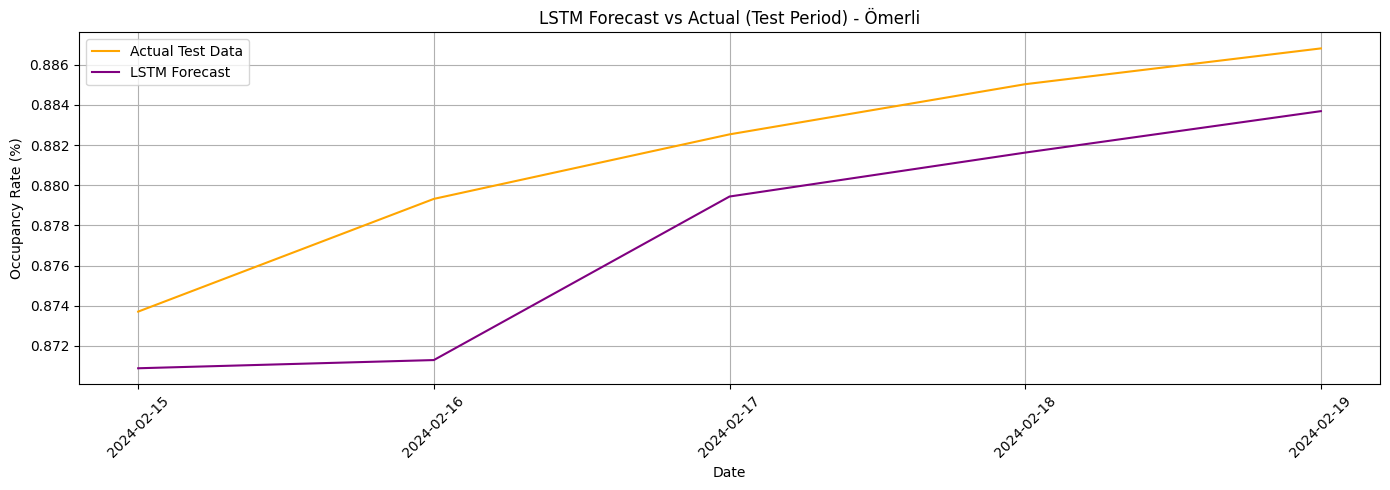


Processing dam: Darlık
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0546
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.6537e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.8517e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.7038e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.7752e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.4032e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1.5851e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3136e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.4049e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0693e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1975e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.5251e-05
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.4744e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9.8480e-05
Epoch 15/50


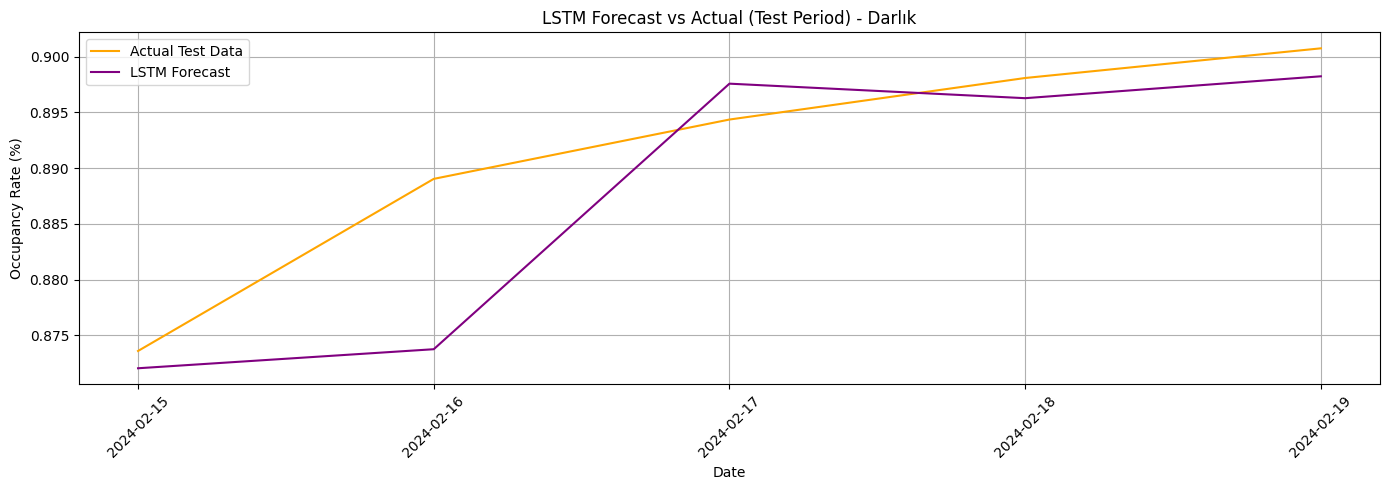


Processing dam: Elmalı
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0542
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.1804e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.4207e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.1860e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.8738e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.1443e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.5405e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.6892e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.8296e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.8037e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.8654e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 2.2193e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.0114e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.7119e-04
Epoch 15/50
529

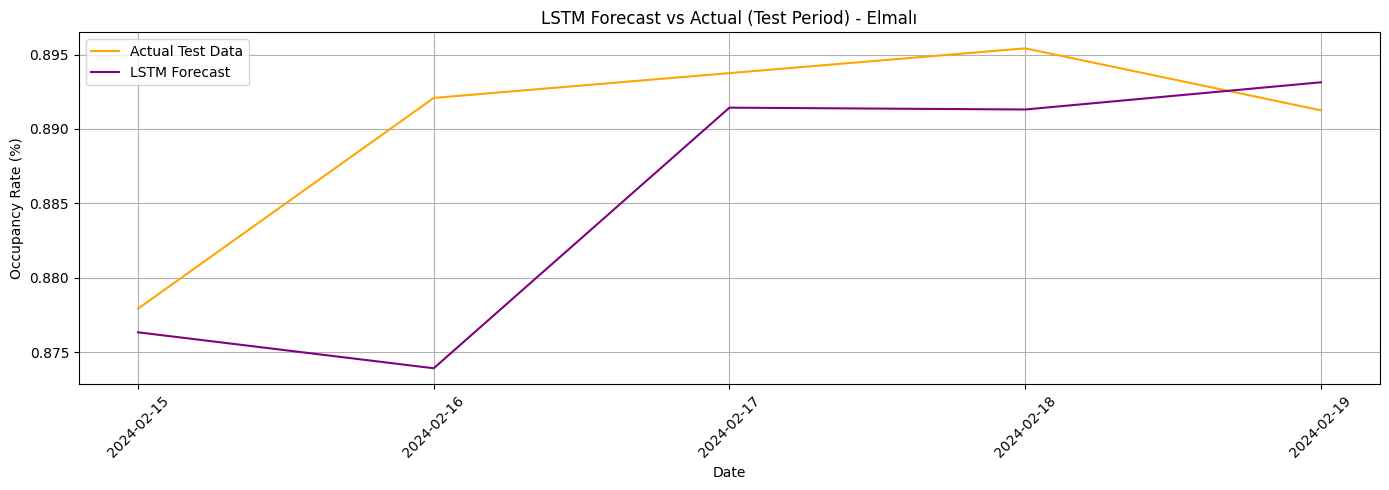


Processing dam: Terkos
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0748
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.0328e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.2403e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.7428e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.1863e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.0362e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.7332e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.4884e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2937e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2824e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.2494e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1813e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0034e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0498e-04
Epoch 15/50
529/

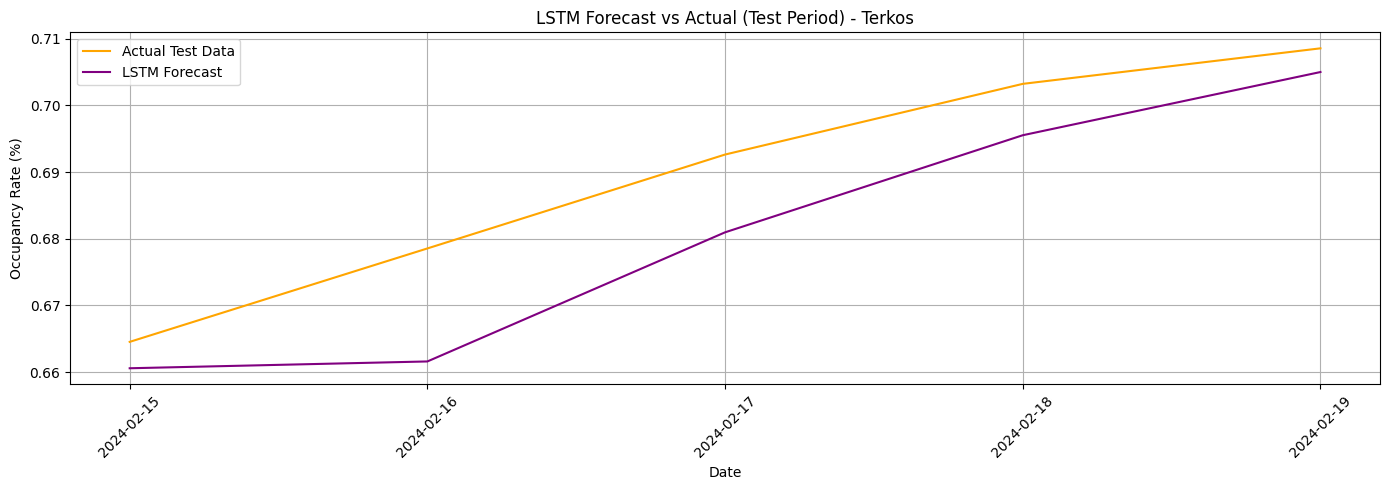


Processing dam: Alibey
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0273
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.4802e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.4139e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.2836e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 2.1766e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 1.6959e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.1324e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.2423e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.0710e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.2106e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.2407e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.0596e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 8.2408e-05
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 8.7482e-05
Ep

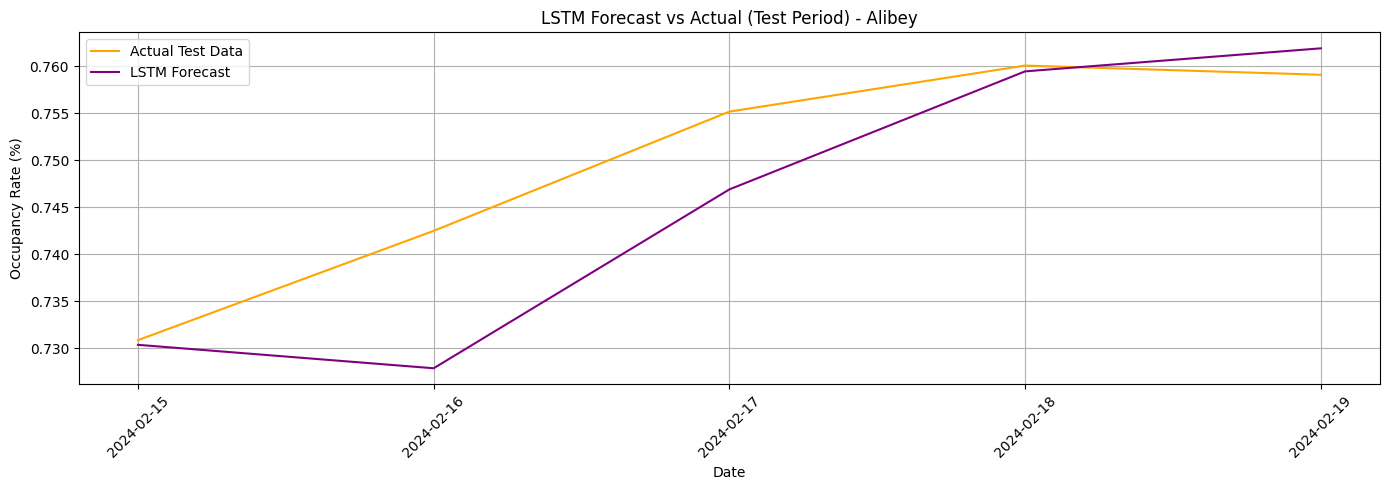


Processing dam: Büyükçekmece
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0237
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.0060e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.5701e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.6359e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.8869e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.4240e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3931e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.4384e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.4778e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1618e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2318e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.0668e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.8944e-05
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1404e-04
Epoch 15/50
529/

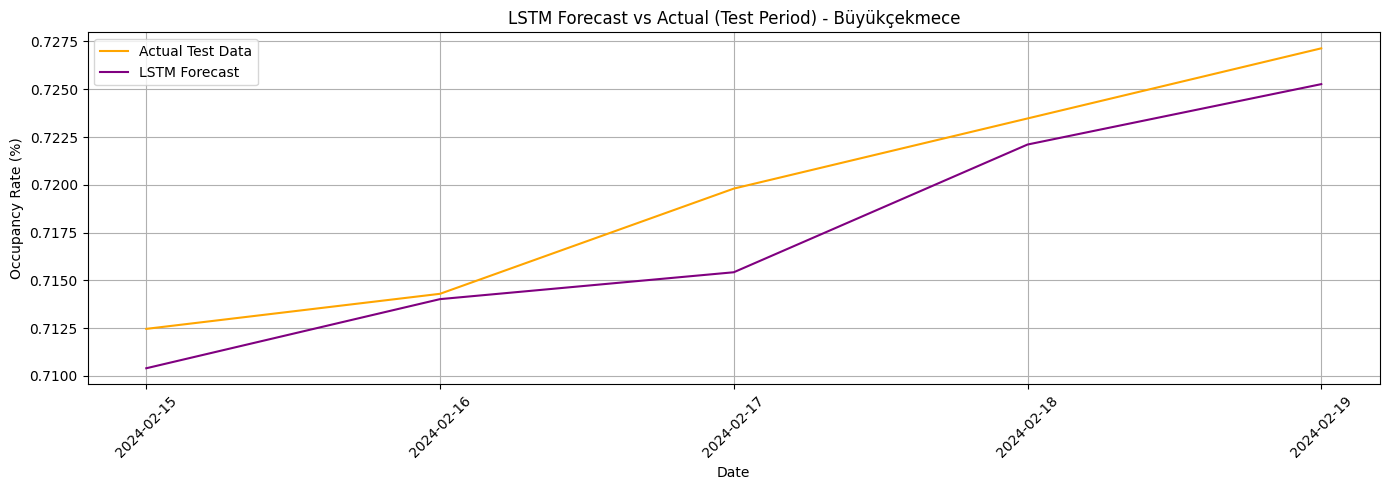


Processing dam: Sazlıdere
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0651
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.4507e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.8377e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2698e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.1270e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.4850e-05
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.8457e-05
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.4294e-05
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.7965e-05
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.6964e-05
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.1819e-05
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.4794e-05
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.7715e-05
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.7654e-05
Epoch 15/50
529/

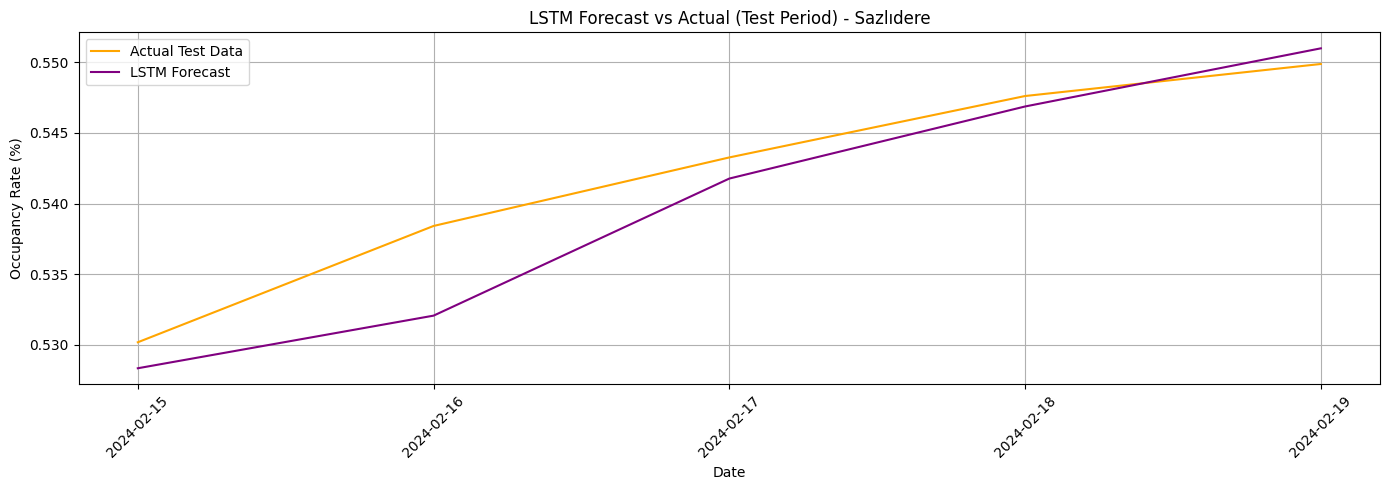


Processing dam: Kazandere
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0480
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.4143e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.3503e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.3722e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0030
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0011
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.9127e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.4235e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.5705e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.6901e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.4331e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.8859e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.3958e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.9592e-04
Epoch 15/50
529/529 ━━━━

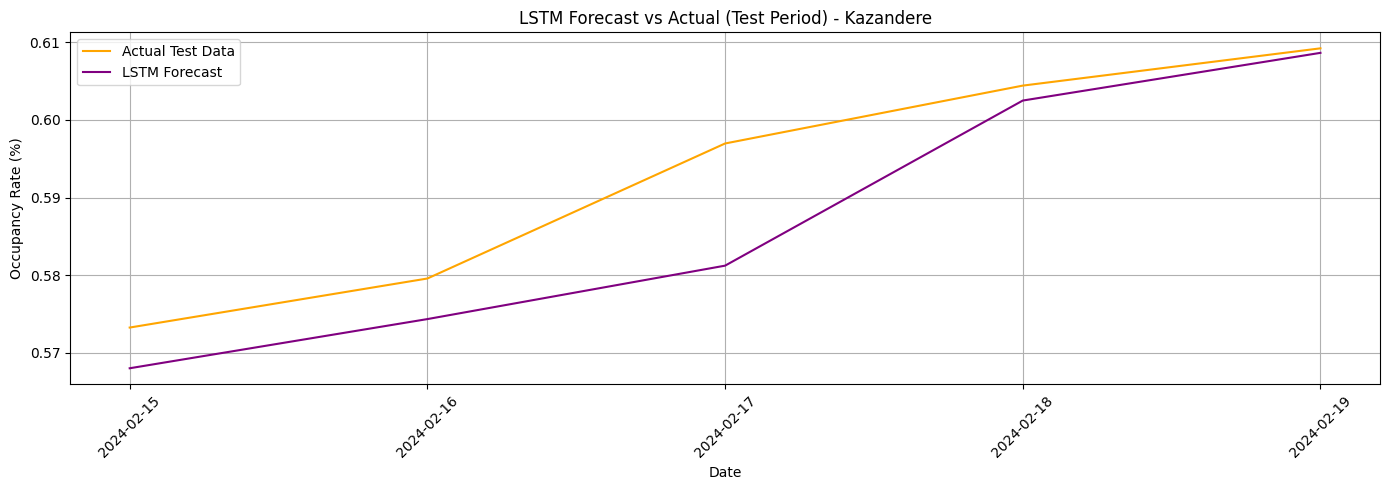


Processing dam: Pabuçdere
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0321
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.4750e-04
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.3655e-04
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.9363e-04
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.6982e-04
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.0299e-04
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.6496e-04
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.4791e-04
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3.4907e-04
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.4786e-04
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.4798e-04
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.9169e-04
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.8584e-04
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.6537e-04
Epoch 15/50
529/

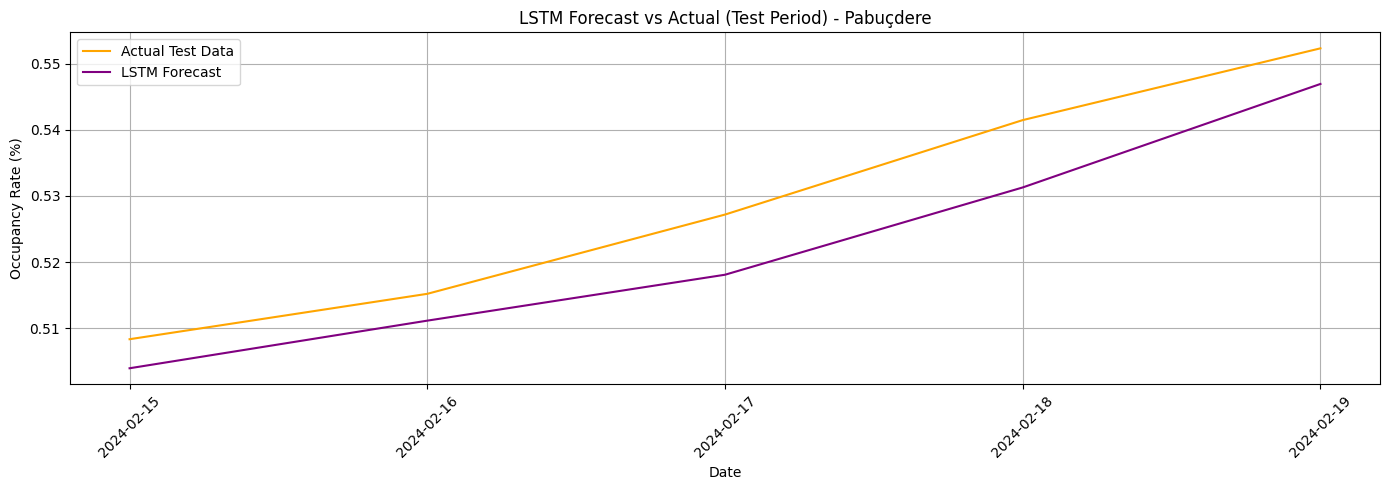


Processing dam: Istrancalar
Epoch 1/50


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


529/529 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0344
Epoch 2/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0037
Epoch 3/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0026
Epoch 4/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0020
Epoch 5/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0022
Epoch 6/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0015
Epoch 7/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0013
Epoch 8/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0017
Epoch 9/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0016
Epoch 10/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0016
Epoch 11/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0019
Epoch 12/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0018
Epoch 13/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0018
Epoch 14/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0014
Epoch 15/50
529/529 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0015


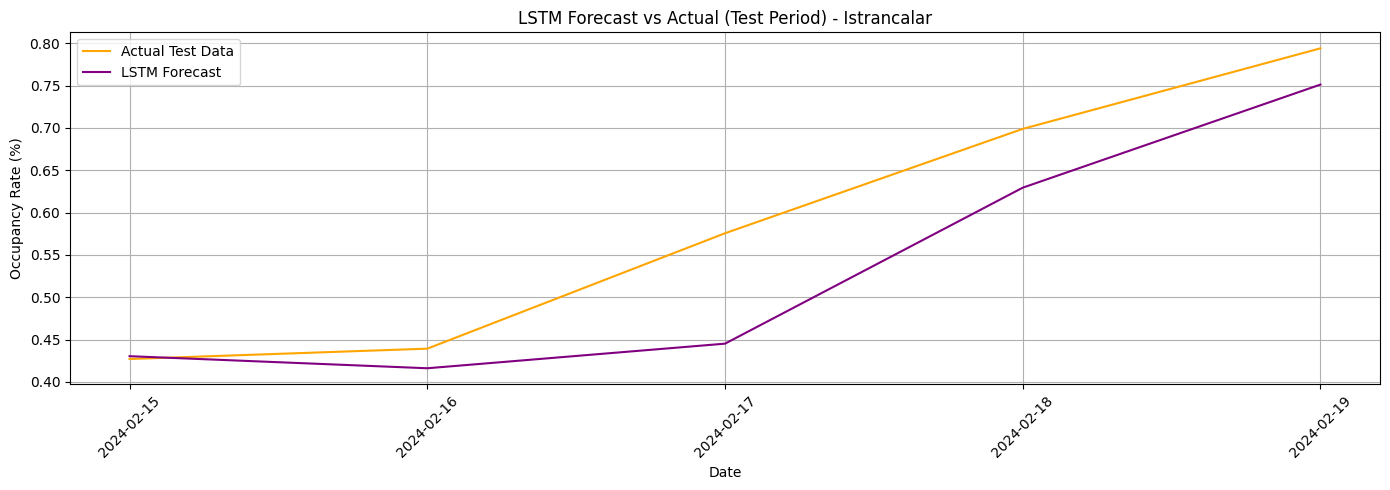

In [1]:
# Importing necessary libraries for data manipulation, modeling, and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Loading the dam-specific dataset
df = pd.read_excel("../data/raw/istanbul-dams-daily-occupancy-rates.xlsx")

# Converting the 'Tarih' column to datetime using automatic detection with dayfirst
df['Tarih'] = pd.to_datetime(df['Tarih'], dayfirst=True)

# Listing dam columns (excluding 'Tarih')
dams = df.columns[1:]

# Defining look-back period
look_back = 30

# Defining a function to prepare sequences for LSTM
def create_sequences(data, look_back=30):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Iterating over each dam to implement LSTM model and evaluate performance
for dam in dams:
    print(f"\nProcessing dam: {dam}")

    dam_df = df[['Tarih', dam]].dropna()
    dam_df = dam_df.set_index('Tarih')

    # Checking if data is sufficient
    if len(dam_df) <= look_back + 5:
        print(f"Not enough data for {dam}, skipping.")
        continue

    # Splitting data ensuring enough sequence length for both train and test sets
    train = dam_df[:- (look_back + 5)]
    test = dam_df[- (look_back + 5):]

    # Scaling the data using MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)

    # Creating sequences for LSTM input
    X_train, y_train = create_sequences(train_scaled, look_back)
    X_test, y_test = create_sequences(test_scaled, look_back)

    # Building the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Training the model
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

    # Making predictions on the test set if data is sufficient
    if len(X_test) > 0:
        predictions = model.predict(X_test)
        predictions_inverse = scaler.inverse_transform(predictions)
        y_test_inverse = scaler.inverse_transform(y_test)

        # Calculating performance metrics
        mae_lstm = mean_absolute_error(y_test_inverse, predictions_inverse)
        rmse_lstm = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))

        print(f"LSTM MAE (Test Set): {mae_lstm:.2f}")
        print(f"LSTM RMSE (Test Set): {rmse_lstm:.2f}")

        # Preparing dates for plotting
        test_dates = test.index[look_back:]

        # Plotting actual vs predicted with clean date formatting
        plt.figure(figsize=(14, 5))
        plt.plot(test_dates, y_test_inverse.flatten(), label='Actual Test Data', color='orange')
        plt.plot(test_dates, predictions_inverse.flatten(), label='LSTM Forecast', color='purple')
        plt.title(f"LSTM Forecast vs Actual (Test Period) - {dam}")
        plt.xlabel("Date")
        plt.ylabel("Occupancy Rate (%)")
        plt.legend()
        plt.grid(True)

        # Setting x-axis date format to show Year-Month-Day only
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Not enough X_test data after sequence creation for {dam}. Skipping evaluation.")
